In [1]:
# Imports
import vtk
import vtkplotlib
import matplotlib.pyplot as plt
OPEN_RENDER_WINDOW = False

In [2]:
# Read in Volume
reader = vtk.vtkStructuredPointsReader()
reader.SetFileName("./Data/2023-05-25-wrist-vol.vtk")
reader.ReadAllScalarsOn()
reader.Update()
wristVolume = reader.GetOutput()

In [3]:
# Set up a camera
cam = vtk.vtkCamera()
cam.SetPosition([-600, 0, 0])
# cam.SetPosition([-300,-500,0])
cam.SetFocalPoint([0.1953125, 0.1953125, 105.0])
cam.SetViewUp([0,0,0])
# cam.SetViewUp([-1,1,1])
cam.SetViewAngle(25)
cam.SetClippingRange(0.1,1000)

In [4]:
# Create the renderer and rendering window
renderer = vtk.vtkRenderer()
renderer.SetBackground(1, 1, 1)

renderWindow = vtk.vtkRenderWindow()
renderWindow.SetOffScreenRendering(not OPEN_RENDER_WINDOW)
renderWindow.SetSize(1760, 1760)
renderWindow.AddRenderer(renderer)

if OPEN_RENDER_WINDOW:
    renderWindowInteractor = vtk.vtkRenderWindowInteractor()
    renderWindowInteractor.SetRenderWindow(renderWindow)

In [5]:
# Set up the volume properties
opacityTransferFunction = vtk.vtkPiecewiseFunction()
opacityTransferFunction.AddPoint(300, 0.00)
opacityTransferFunction.AddPoint(700, 0.05)

volumeProperty = vtk.vtkVolumeProperty()
volumeProperty.SetInterpolationTypeToLinear()
# volumeProperty.SetInterpolationTypeToNearest()
volumeProperty.ShadeOn()
volumeProperty.SetAmbient(0.1)
volumeProperty.SetDiffuse(0.9)
volumeProperty.SetSpecular(0.2)
volumeProperty.SetScalarOpacity(opacityTransferFunction)

In [6]:
# Raycast mapper
volumeMapper = vtk.vtkGPUVolumeRayCastMapper()
volumeMapper.SetInputData(wristVolume)
volumeMapper.SetBlendModeToComposite()
# volumeMapper.SetSampleDistance(0.5) # Default is 1.0

In [7]:
# Volume to be rendered
volume = vtk.vtkVolume()
volume.SetMapper(volumeMapper)
volume.SetProperty(volumeProperty)

In [8]:
# Render the image
renderer.AddVolume(volume)
renderer.SetActiveCamera(cam)
renderWindow.Render()

if OPEN_RENDER_WINDOW:
    renderWindowInteractor.Start() 

In [9]:
# Get the rendered volume
window2Image = vtk.vtkWindowToImageFilter()
window2Image.SetInput(renderWindow)
window2Image.SetScale(1)
window2Image.SetInputBufferTypeToRGB()
window2Image.Update()

In [10]:
# Convert from RGB to grey
rgb2Grey = vtk.vtkImageLuminance()
rgb2Grey.SetInputConnection(window2Image.GetOutputPort())
rgb2Grey.Update()

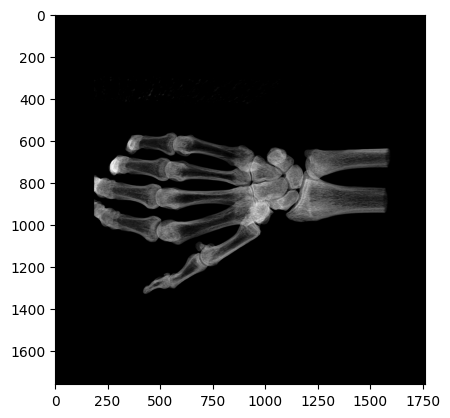

In [11]:
renderedImage = rgb2Grey.GetOutput()
img = vtkplotlib.image_io.vtkimagedata_to_array(renderedImage)
plt.imshow(img,cmap='Greys')

In [12]:
# Write Image
writer = vtk.vtkTIFFWriter()
writer.SetCompressionToPackBits()
writer.SetFileName("./Data/wrist_vol_test_render.tif")
writer.SetInputData(rgb2Grey.GetOutput())
writer.Update()
writer.Write()